In [1]:
!pip install -q torch torchvision torchaudio transformers scikit-learn librosa

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import torch
import librosa
from transformers import Wav2Vec2Processor, Wav2Vec2Model

In [3]:
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wav2Vec2Model(
  (feature_extractor): Wav2Vec2FeatureEncoder(
    (conv_layers): ModuleList(
      (0): Wav2Vec2GroupNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (activation): GELUActivation()
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
      )
      (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
      (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
    )
  )
  (feature_projection): Wav2Vec2FeatureProjection(
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (projection): Linear(in_features=512, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Wav2Vec2Encoder(
    (pos_conv_embed): Wav2Vec2PositionalConvEmbedding(
  

In [4]:
def generate_sine_wave(freq, duration, sr=16000):
    t = np.linspace(0, duration, int(sr * duration), endpoint=False)
    audio = 0.5 * np.sin(2 * np.pi * freq * t)
    return audio

In [13]:
sr = 16000
duration = 2.0
frequencies = np.random.uniform(200, 800, 20)
audio_signals = [generate_sine_wave(freq, duration, sr) for freq in frequencies]

In [14]:
def extract_embeddings(audio, sr=16000):
    inputs = processor(audio, sampling_rate=sr, return_tensors="pt", padding=True)
    inputs = {key: val.to(device) for key, val in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)

    return outputs.last_hidden_state.mean(dim=1).cpu().numpy()

In [15]:
embeddings = np.array([extract_embeddings(signal, sr)[0] for signal in audio_signals])

In [16]:
num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
labels = kmeans.fit_predict(embeddings)

In [17]:
sil_score = silhouette_score(embeddings, labels)
print(f"Silhouette Score: {sil_score:.3f}")

Silhouette Score: 0.256


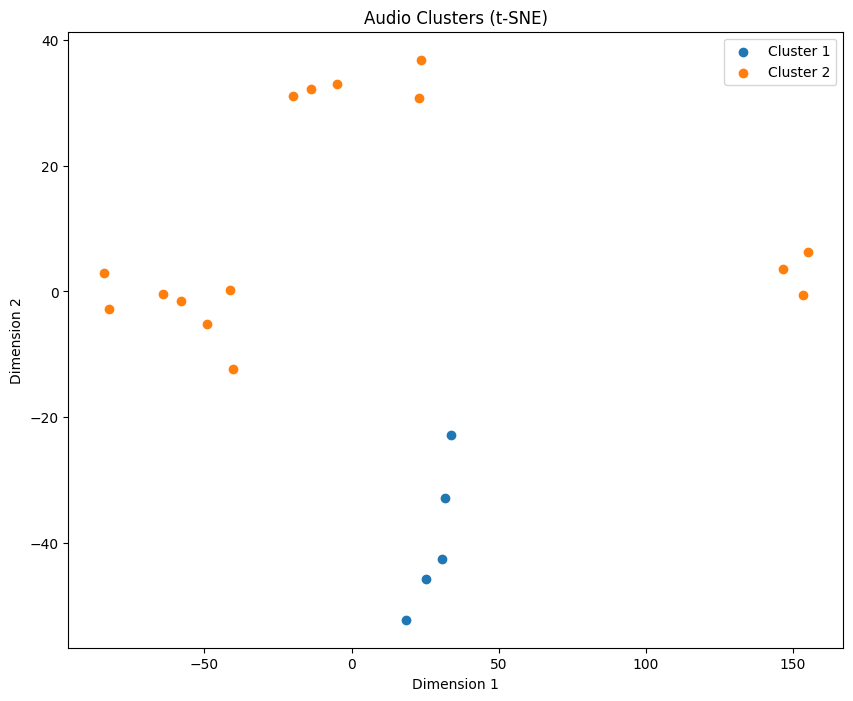

In [18]:
tsne = TSNE(n_components=2, perplexity=2, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 8))
for cluster in range(num_clusters):
    cluster_indices = np.where(labels == cluster)
    plt.scatter(
        reduced_embeddings[cluster_indices, 0],
        reduced_embeddings[cluster_indices, 1],
        label=f"Cluster {cluster + 1}"
    )
plt.title("Audio Clusters (t-SNE)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.show()

In [19]:
for cluster in range(num_clusters):
    print(f"Cluster {cluster + 1}:")
    for idx, freq in enumerate(frequencies):
        if labels[idx] == cluster:
            print(f"  - Audio with frequency {freq} Hz")
    print()

Cluster 1:
  - Audio with frequency 704.1136668079616 Hz
  - Audio with frequency 702.890009425156 Hz
  - Audio with frequency 585.802156576754 Hz
  - Audio with frequency 200.0783849920566 Hz
  - Audio with frequency 290.613450324328 Hz

Cluster 2:
  - Audio with frequency 320.6082413216285 Hz
  - Audio with frequency 242.63809567859698 Hz
  - Audio with frequency 486.3422381293083 Hz
  - Audio with frequency 698.9773611045186 Hz
  - Audio with frequency 454.91855300262944 Hz
  - Audio with frequency 309.66831547154834 Hz
  - Audio with frequency 501.56395304280574 Hz
  - Audio with frequency 538.8954741459238 Hz
  - Audio with frequency 455.96658229663586 Hz
  - Audio with frequency 519.0517734616496 Hz
  - Audio with frequency 353.6450763107223 Hz
  - Audio with frequency 473.3554233205032 Hz
  - Audio with frequency 458.0473488530977 Hz
  - Audio with frequency 503.7863026678367 Hz
  - Audio with frequency 429.0794872089207 Hz

